# Comprehensive Sentiment Analysis: Airbnb, Hotels, and TripAdvisor


## Reference
Inspired by: https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial

## Section 1: Setup & Dependencies

This section loads all necessary libraries and prepares the environment.

In [1]:
# Core data processing
import pandas as pd
import numpy as np
import os
from datetime import datetime
from collections import Counter
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import langid
from tqdm.notebook import tqdm

# Deep learning
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

print("✓ All dependencies loaded successfully")

✓ All dependencies loaded successfully


### 1.1 Download Required NLTK Resources

In [2]:
nltk.download('punkt', force=True)
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')

print("✓ NLTK resources downloaded successfully")

[nltk_data] Downloading package punkt to /Users/juliuseg/nltk_data...


✓ NLTK resources downloaded successfully


[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/juliuseg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/juliuseg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 1.2 Initialize Sentiment Analysis Models

In [3]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()
print("✓ VADER initialized")

# Initialize RoBERTa
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Use GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using Metal Performance Shaders (Mac GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✓ Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("⚠ Using CPU")

model.to(device)
model.eval()
print(f"✓ RoBERTa loaded on {device}")

✓ VADER initialized
✓ Using Metal Performance Shaders (Mac GPU)
✓ RoBERTa loaded on mps


## Section 2: Data Loading & Preprocessing

### 2.1 Load Airbnb Reviews with Clustering

In [4]:
# Load cluster data
cluster_df = pd.read_csv('data/listings_clustered.csv')
cluster_df = cluster_df.rename(columns={"id": "listing_id"})

print(f"Cluster data shape: {cluster_df.shape}")
print(f"Unique listings: {cluster_df['listing_id'].nunique()}")
print(f"Number of clusters: {cluster_df['cluster_kmeans'].nunique()}")

Cluster data shape: (13254, 2)
Unique listings: 13254
Number of clusters: 16


In [5]:
# Load Airbnb sentiment results
airbnb_results = pd.read_csv('results_df_20251118_125309.csv')
airbnb_results["Review"] = airbnb_results["Review"].str.replace(r"<br\s*/?", "", regex=True)

print(f"Airbnb reviews shape: {airbnb_results.shape}")

Airbnb reviews shape: (140342, 13)


In [6]:
# Merge with clusters
airbnb_merged = airbnb_results[
    airbnb_results["listing_id"].isin(cluster_df["listing_id"])
].merge(cluster_df, on="listing_id", how="left")

print(f"Merged Airbnb data shape: {airbnb_merged.shape}")

Merged Airbnb data shape: (94440, 14)


### 2.2 Load and Preprocess Hotel Reviews

In [7]:
# Load hotel data
hotel_df_full = pd.read_csv('data/reviews_hotel1.csv')
print(f"Full hotel dataset: {hotel_df_full.shape}")

# Clean
hotel_df_full = hotel_df_full[hotel_df_full['reviews.text'].notna()]
hotel_df_full = hotel_df_full[hotel_df_full['reviews.rating'].isin([1.0, 2.0, 3.0, 4.0, 5.0])]
hotel_df = hotel_df_full.head(5000).reset_index()

print(f"Hotel dataset after filtering: {hotel_df.shape}")

Full hotel dataset: (35912, 4)
Hotel dataset after filtering: (5000, 5)


In [8]:
# Language filtering and text preparation
hotel_df = hotel_df[hotel_df["reviews.text"].apply(
    lambda x: langid.classify(str(x))[0] == "en"
)].copy()

hotel_df['Review'] = hotel_df['reviews.title'] + '\\n' + hotel_df['reviews.text']
hotel_df.drop(columns=['reviews.title', 'reviews.text'], inplace=True)
hotel_df.rename(columns={'reviews.rating': 'Rating'}, inplace=True)

print(f"Hotel dataset after language filtering: {hotel_df.shape}")

Hotel dataset after language filtering: (4806, 4)


In [9]:
# Load training data from END of hotel dataset (not used in analysis)
hotel_train_df_full = pd.read_csv('data/reviews_hotel1.csv')
hotel_train_df_full = hotel_train_df_full[hotel_train_df_full['reviews.text'].notna()]
hotel_train_df_full = hotel_train_df_full[hotel_train_df_full['reviews.rating'].isin([1.0, 2.0, 3.0, 4.0, 5.0])]

# Get last 5000 (NOT first 5000)
hotel_train_df = hotel_train_df_full.iloc[-5000:].reset_index(drop=True)

# Language filtering
hotel_train_df = hotel_train_df[hotel_train_df["reviews.text"].apply(
    lambda x: langid.classify(str(x))[0] == "en"
)].copy()

# Prepare text
hotel_train_df['Review'] = hotel_train_df['reviews.title'] + '\n' + hotel_train_df['reviews.text']
hotel_train_df.drop(columns=['reviews.title', 'reviews.text'], inplace=True)
hotel_train_df.rename(columns={'reviews.rating': 'Rating'}, inplace=True)

print(f"Training dataset (END 5000): {hotel_train_df.shape}")
print(f"Rating distribution:\n{hotel_train_df['Rating'].value_counts().sort_index()}")


Training dataset (END 5000): (4698, 3)
Rating distribution:
Rating
1.0     380
2.0     357
3.0     691
4.0    1372
5.0    1898
Name: count, dtype: int64


### 2.3 Load and Preprocess TripAdvisor Reviews

In [10]:
# Load TripAdvisor data
tripadvisor_df_full = pd.read_csv('data/tripadvisor_hotel_reviews.csv')
print(f"Full TripAdvisor dataset: {tripadvisor_df_full.shape}")

tripadvisor_df = tripadvisor_df_full.head(500).reset_index()

# Language filtering
tripadvisor_df = tripadvisor_df[
    tripadvisor_df["Review"].apply(lambda x: langid.classify(str(x))[0] == "en")
].copy()

print(f"TripAdvisor dataset after filtering: {tripadvisor_df.shape}")

Full TripAdvisor dataset: (20491, 2)
TripAdvisor dataset after filtering: (497, 3)


## Section 3: Sentiment Analysis Functions

### 3.1 RoBERTa Sentiment Scoring

In [11]:
def get_roberta_scores(text, tokenizer, model, device):
    """Get RoBERTa sentiment scores for text."""
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    encoded = {k: v.to(device) for k, v in encoded.items()}
    
    with torch.no_grad():
        output = model(**encoded)
    
    scores = output.logits[0].cpu().numpy()
    scores = softmax(scores)
    
    return {
        'roberta_neg': float(scores[0]),
        'roberta_neu': float(scores[1]),
        'roberta_pos': float(scores[2])
    }

### 3.2 Compute Sentiment for Dataset

In [12]:
def compute_sentiment_scores(df, text_column='Review', id_column='index'):
    """Compute VADER and RoBERTa sentiment scores."""
    results = {}
    
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Computing sentiment"):
        try:
            text = row[text_column]
            
            if not isinstance(text, str) or len(text.strip()) == 0:
                continue
            
            row_id = row[id_column]
            
            # VADER
            vader_result = sia.polarity_scores(text)
            vader_renamed = {f"vader_{k}": v for k, v in vader_result.items()}
            
            # RoBERTa
            roberta_result = get_roberta_scores(text, tokenizer, model, device)
            
            # Combine
            combined = {**vader_renamed, **roberta_result}
            results[row_id] = combined
            
        except Exception as e:
            continue
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results).T.reset_index()
    results_df.rename(columns={'index': id_column}, inplace=True)
    merged = results_df.merge(df, on=id_column, how='left')
    
    # Add label
    roberta_cols = ['roberta_neg', 'roberta_neu', 'roberta_pos']
    merged['roberta_label'] = merged[roberta_cols].idxmax(axis=1)
    
    return merged

### 3.3 Locally trained models (Logistic Regression and Support Vector Machine)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline

# --- Sentiment mapping ---
def map_sentiment(rating):
    if rating <= 2:
        return -1
    elif rating == 3:
        return 0
    return 1

df_train = hotel_df.copy().drop(columns=['reviews.date'])
df_test = tripadvisor_df.copy()

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

X_train = df_train['Review']
X_train = X_train.fillna("").astype(str)
y_train = df_train['Rating'].apply(map_sentiment)

X_test = df_test['Review']
y_test = df_test['Rating'].apply(map_sentiment)


# ----------------------------------------------------
# Model configs
# ----------------------------------------------------
configs = [
    {
        "name": "tfidf_logreg",
        "vectorizer": TfidfVectorizer,
        "classifier": LogisticRegression,
        "clf_params": {"max_iter": 1000}
    },
    {
        "name": "count_svm",
        "vectorizer": CountVectorizer,
        "classifier": LinearSVC,
        "clf_params": {"max_iter": 2000}
    },
]

results = []

# ----------------------------------------------------
# Training & evaluation
# ----------------------------------------------------
for cfg in configs:
    print(f"\n=== Training model: {cfg['name']} ===")

    vec_cls = cfg["vectorizer"]
    clf_cls = cfg["classifier"]
    clf_params = cfg.get("clf_params", {})

    pipe = Pipeline([
        ("vect", vec_cls()),
        ("clf", clf_cls(**clf_params))
    ])

    # fit
    pipe.fit(X_train, y_train)
    print("→ Training done.")

    # predict
    preds = pipe.predict(X_test)
    print("→ Prediction done.")

    # scores
    acc = accuracy_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    cm = confusion_matrix(y_test, preds).tolist()
    f1 = f1_score(y_test, preds, average="macro")

    print(f"Accuracy: {acc:.3f}")
    print(f"F1: {f1:.3f}")
    print(f"MAE: {mae:.3f}")
    print("Confusion matrix:")
    print(np.array(cm))

    # append
    results.append({
        "model": cfg["name"],
        "accuracy": acc,
        "mae": mae,
        "y_true": y_test.tolist(),
        "y_pred": preds.tolist(),
        "confusion_matrix": cm,
        "f1_score": f1
    })



Train shape: (4806, 3)
Test shape: (497, 3)

=== Training model: tfidf_logreg ===
→ Training done.
→ Prediction done.
Accuracy: 0.746
F1: 0.592
MAE: 0.334
Confusion matrix:
[[ 73  11  38]
 [  7  12  59]
 [  2   9 286]]

=== Training model: count_svm ===
→ Training done.
→ Prediction done.
Accuracy: 0.652
F1: 0.568
MAE: 0.416
Confusion matrix:
[[ 66  37  19]
 [ 19  32  27]
 [ 15  56 226]]


/Users/juliuseg/DTU/CompTools/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Section 4: Compute Sentiment Scores

In [14]:
print("\n" + "="*80)
print("COMPUTING VADER SCORES FOR TRAINING DATA")
print("="*80)
hotel_train_vader = {}
for idx, row in tqdm(hotel_train_df.iterrows(), total=len(hotel_train_df), desc="VADER"):
    text = row['Review']
    if isinstance(text, str) and len(text.strip()) > 0:
        hotel_train_vader[idx] = sia.polarity_scores(text)

hotel_train_sentiment = pd.DataFrame(hotel_train_vader).T.reset_index()
hotel_train_sentiment.columns = ['row_idx'] + list(hotel_train_sentiment.columns[1:])
hotel_train_sentiment = hotel_train_sentiment.merge(
    hotel_train_df[['Rating']].reset_index().rename(columns={'index': 'row_idx'}), 
    on='row_idx', how='left'
)
print(f"✓ Training sentiment computed: {hotel_train_sentiment.shape}")



COMPUTING VADER SCORES FOR TRAINING DATA


VADER:   0%|          | 0/4698 [00:00<?, ?it/s]

✓ Training sentiment computed: (4587, 6)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

print("\n" + "="*80)
print("TRAINING LOGISTIC REGRESSION ON VADER FEATURES")
print("="*80)

# Prepare training data
X_train = hotel_train_sentiment[['neg', 'neu', 'pos', 'compound']].values
y_train = hotel_train_sentiment['Rating'].values

# Train logistic regression
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial')
log_reg.fit(X_train, y_train)

# Predict on training set
train_pred = log_reg.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"✓ Logistic Regression model trained!")

# Map to sentiment labels
def logistic_pred_to_sentiment(rating):
    if rating <= 2:
        return 'neg'
    elif rating == 3:
        return 'neu'
    else:
        return 'pos'

print(f"Logistic Regression ready to use on test data")



TRAINING LOGISTIC REGRESSION ON VADER FEATURES
Training Accuracy: 0.4567
✓ Logistic Regression model trained!
Logistic Regression ready to use on test data


/Users/juliuseg/DTU/CompTools/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [16]:
print("\n" + "="*80)
print("HOTEL REVIEWS SENTIMENT ANALYSIS")
print("="*80)
hotel_sentiment = compute_sentiment_scores(hotel_df, text_column='Review', id_column='index')
print(f"✓ Complete: {hotel_sentiment.shape}")


HOTEL REVIEWS SENTIMENT ANALYSIS


Computing sentiment:   0%|          | 0/4806 [00:00<?, ?it/s]

✓ Complete: (4732, 12)


In [17]:
print("\n" + "="*80)
print("TRIPADVISOR REVIEWS SENTIMENT ANALYSIS")
print("="*80)
tripadvisor_sentiment = compute_sentiment_scores(tripadvisor_df, text_column='Review', id_column='index')
print(f"✓ Complete: {tripadvisor_sentiment.shape}")


TRIPADVISOR REVIEWS SENTIMENT ANALYSIS


Computing sentiment:   0%|          | 0/497 [00:00<?, ?it/s]

✓ Complete: (497, 11)


## Section 4.5: Model Evaluation - Hotel Dataset

Evaluate VADER and RoBERTa predictions against actual hotel ratings


In [18]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Map ratings to sentiment labels: 1-2 = neg, 3 = neu, 4-5 = pos
def map_rating_to_sentiment(rating):
    if rating <= 2:
        return 'neg'
    elif rating == 3:
        return 'neu'
    else:  # rating >= 4
        return 'pos'

hotel_sentiment['true_label'] = hotel_sentiment['Rating'].apply(map_rating_to_sentiment)

# VADER (argmax - baseline)
vader_cols = ['vader_neg', 'vader_neu', 'vader_pos']
hotel_sentiment['vader_pred'] = hotel_sentiment[vader_cols].idxmax(axis=1).str.replace('vader_', '', regex=False)

# VADER (Logistic Regression - improved)
X_test = hotel_sentiment[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']].values
vader_logistic_pred = log_reg.predict(X_test)
hotel_sentiment['vader_logistic_pred'] = [logistic_pred_to_sentiment(int(x)) for x in vader_logistic_pred]

# RoBERTa: Get argmax
roberta_cols = ['roberta_neg', 'roberta_neu', 'roberta_pos']
hotel_sentiment['roberta_pred'] = hotel_sentiment[roberta_cols].idxmax(axis=1).str.replace('roberta_', '', regex=False)

print("=" * 80)
print("HOTEL SENTIMENT MODEL EVALUATION")
print("=" * 80)
print(f"\nTrue label distribution:\n{hotel_sentiment['true_label'].value_counts()}")
print(f"\nVADER (argmax) predictions:\n{hotel_sentiment['vader_pred'].value_counts()}")
print(f"\nVADER (Logistic Regression) predictions:\n{hotel_sentiment['vader_logistic_pred'].value_counts()}")
print(f"\nRoBERTa predictions:\n{hotel_sentiment['roberta_pred'].value_counts()}")


HOTEL SENTIMENT MODEL EVALUATION

True label distribution:
true_label
pos    3278
neg     757
neu     697
Name: count, dtype: int64

VADER (argmax) predictions:
vader_pred
neu    4421
pos     307
neg       4
Name: count, dtype: int64

VADER (Logistic Regression) predictions:
vader_logistic_pred
pos    3874
neg     566
neu     292
Name: count, dtype: int64

RoBERTa predictions:
roberta_pred
pos    3495
neg     914
neu     323
Name: count, dtype: int64


In [19]:
# VADER (argmax) - baseline
vader_accuracy = accuracy_score(hotel_sentiment['true_label'], hotel_sentiment['vader_pred'])
vader_f1 = f1_score(hotel_sentiment['true_label'], hotel_sentiment['vader_pred'], average='weighted')

print("\n" + "=" * 80)
print("VADER (ARGMAX) - BASELINE")
print("=" * 80)
print(f"Accuracy: {vader_accuracy:.4f}")
print(f"F1-Score (weighted): {vader_f1:.4f}")
print("\nClassification Report:")
print(classification_report(hotel_sentiment['true_label'], hotel_sentiment['vader_pred']))

# VADER (Logistic Regression) - improved
vader_logistic_accuracy = accuracy_score(hotel_sentiment['true_label'], hotel_sentiment['vader_logistic_pred'])
vader_logistic_f1 = f1_score(hotel_sentiment['true_label'], hotel_sentiment['vader_logistic_pred'], average='weighted')

print("\n" + "=" * 80)
print("VADER (LOGISTIC REGRESSION) - IMPROVED")
print("=" * 80)
print(f"Accuracy: {vader_logistic_accuracy:.4f}")
print(f"F1-Score (weighted): {vader_logistic_f1:.4f}")
print(f"Improvement: {(vader_logistic_accuracy - vader_accuracy)*100:.2f}% accuracy gain")
print("\nClassification Report:")
print(classification_report(hotel_sentiment['true_label'], hotel_sentiment['vader_logistic_pred']))

# RoBERTa
roberta_accuracy = accuracy_score(hotel_sentiment['true_label'], hotel_sentiment['roberta_pred'])
roberta_f1 = f1_score(hotel_sentiment['true_label'], hotel_sentiment['roberta_pred'], average='weighted')

print("\n" + "=" * 80)
print("RoBERTa PERFORMANCE")
print("=" * 80)
print(f"Accuracy: {roberta_accuracy:.4f}")
print(f"F1-Score (weighted): {roberta_f1:.4f}")
print("\nClassification Report:")
print(classification_report(hotel_sentiment['true_label'], hotel_sentiment['roberta_pred']))



VADER (ARGMAX) - BASELINE
Accuracy: 0.2027
F1-Score (weighted): 0.1486

Classification Report:
              precision    recall  f1-score   support

         neg       0.25      0.00      0.00       757
         neu       0.15      0.97      0.26       697
         pos       0.92      0.09      0.16      3278

    accuracy                           0.20      4732
   macro avg       0.44      0.35      0.14      4732
weighted avg       0.70      0.20      0.15      4732


VADER (LOGISTIC REGRESSION) - IMPROVED
Accuracy: 0.7337
F1-Score (weighted): 0.6962
Improvement: 53.11% accuracy gain

Classification Report:
              precision    recall  f1-score   support

         neg       0.66      0.49      0.56       757
         neu       0.19      0.08      0.11       697
         pos       0.79      0.93      0.85      3278

    accuracy                           0.73      4732
   macro avg       0.54      0.50      0.51      4732
weighted avg       0.68      0.73      0.70      4732


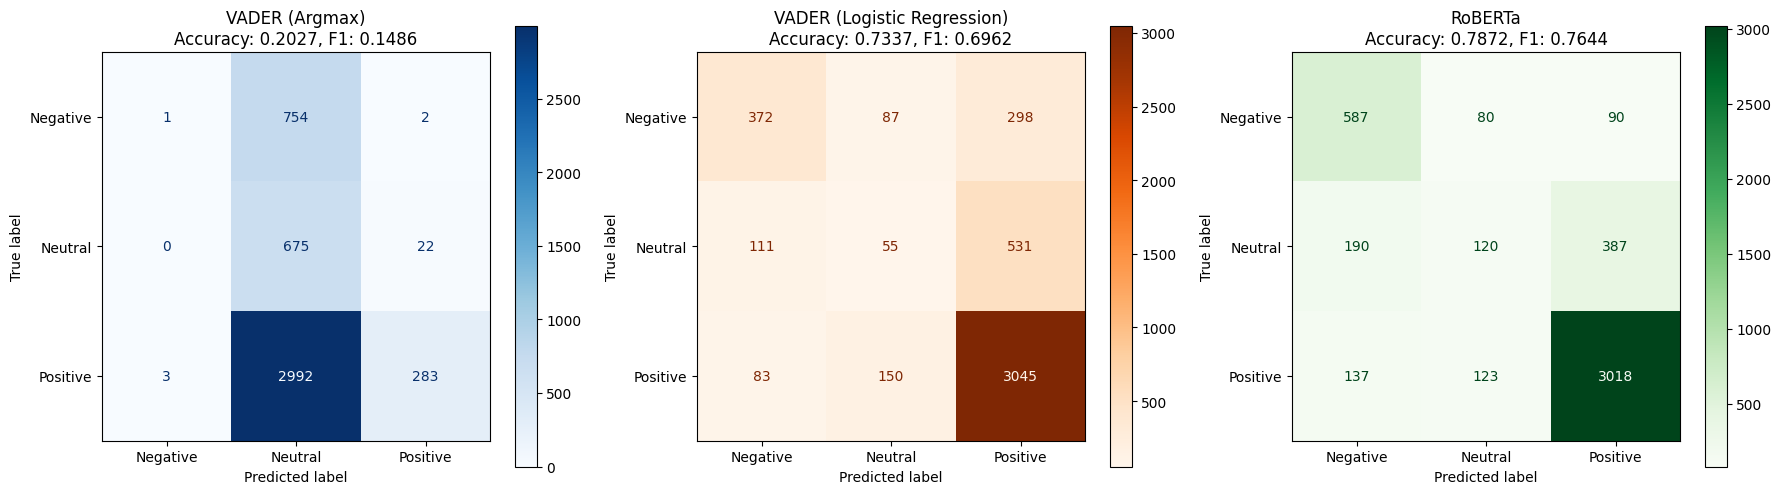


MODEL COMPARISON - ALL THREE
                      Model  Accuracy  F1-Score
             VADER (Argmax)  0.202663  0.148641
VADER (Logistic Regression)  0.733728  0.696213
                    RoBERTa  0.787194  0.764403

Best Model: RoBERTa
Logistic Regression Improvement: 53.11%


In [20]:
# Comparison visualization - 3 models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

from sklearn.metrics import ConfusionMatrixDisplay

# VADER (Argmax)
ConfusionMatrixDisplay.from_predictions(
    hotel_sentiment['true_label'], 
    hotel_sentiment['vader_pred'],
    display_labels=['Negative', 'Neutral', 'Positive'],
    ax=axes[0],
    cmap='Blues'
)
axes[0].set_title(f'VADER (Argmax)\nAccuracy: {vader_accuracy:.4f}, F1: {vader_f1:.4f}')

# VADER (Logistic Regression)
ConfusionMatrixDisplay.from_predictions(
    hotel_sentiment['true_label'], 
    hotel_sentiment['vader_logistic_pred'],
    display_labels=['Negative', 'Neutral', 'Positive'],
    ax=axes[1],
    cmap='Oranges'
)
axes[1].set_title(f'VADER (Logistic Regression)\nAccuracy: {vader_logistic_accuracy:.4f}, F1: {vader_logistic_f1:.4f}')

# RoBERTa
ConfusionMatrixDisplay.from_predictions(
    hotel_sentiment['true_label'], 
    hotel_sentiment['roberta_pred'],
    display_labels=['Negative', 'Neutral', 'Positive'],
    ax=axes[2],
    cmap='Greens'
)
axes[2].set_title(f'RoBERTa\nAccuracy: {roberta_accuracy:.4f}, F1: {roberta_f1:.4f}')

plt.tight_layout()
plt.show()

# Summary comparison
print("\n" + "=" * 80)
print("MODEL COMPARISON - ALL THREE")
print("=" * 80)
comparison_df = pd.DataFrame({
    'Model': ['VADER (Argmax)', 'VADER (Logistic Regression)', 'RoBERTa'],
    'Accuracy': [vader_accuracy, vader_logistic_accuracy, roberta_accuracy],
    'F1-Score': [vader_f1, vader_logistic_f1, roberta_f1]
})
print(comparison_df.to_string(index=False))

best_model = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
print(f"\nBest Model: {best_model}")
print(f"Logistic Regression Improvement: {(vader_logistic_accuracy - vader_accuracy)*100:.2f}%")


## Section 5: Results Visualization

### 5.1 Airbnb Sentiment Distribution

/var/folders/lc/hb2ry3c568xg7y9qdybnfm280000gn/T/ipykernel_41388/1834850014.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='coolwarm')


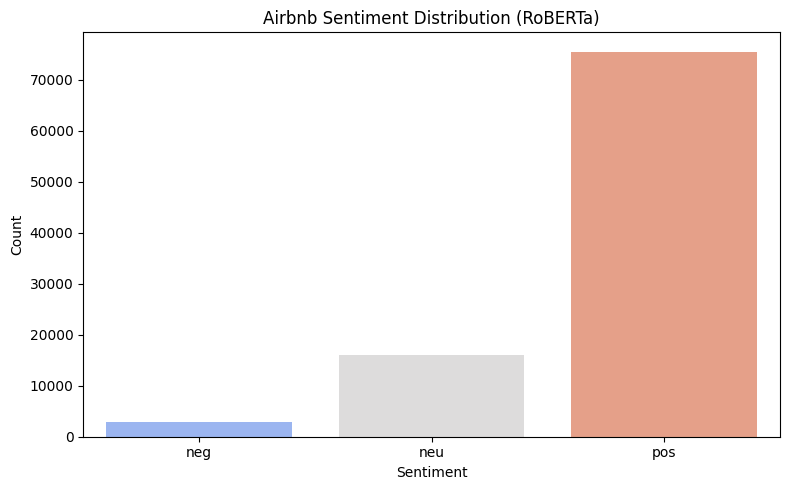

neg     2939
neu    15942
pos    75559
Name: count, dtype: int64


In [21]:
roberta_cols = ['roberta_neg', 'roberta_neu', 'roberta_pos']
airbnb_sentiment_argmax = airbnb_merged[roberta_cols].idxmax(axis=1).str.replace('roberta_', '', regex=False)
counts = airbnb_sentiment_argmax.value_counts().reindex(['neg', 'neu', 'pos'])

plt.figure(figsize=(8, 5))
sns.barplot(x=counts.index, y=counts.values, palette='coolwarm')
plt.title('Airbnb Sentiment Distribution (RoBERTa)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print(counts)

<Figure size 1400x600 with 0 Axes>

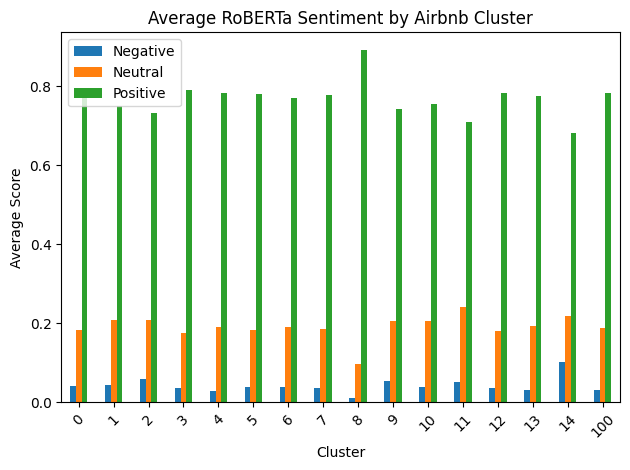

In [22]:
cluster_sentiment = airbnb_merged.groupby("cluster_kmeans")[roberta_cols].mean()

plt.figure(figsize=(14, 6))
cluster_sentiment.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Average Score')
plt.title('Average RoBERTa Sentiment by Airbnb Cluster')
plt.xticks(rotation=45)
plt.legend(['Negative', 'Neutral', 'Positive'])
plt.tight_layout()
plt.show()

### 5.2 Hotel Sentiment Analysis

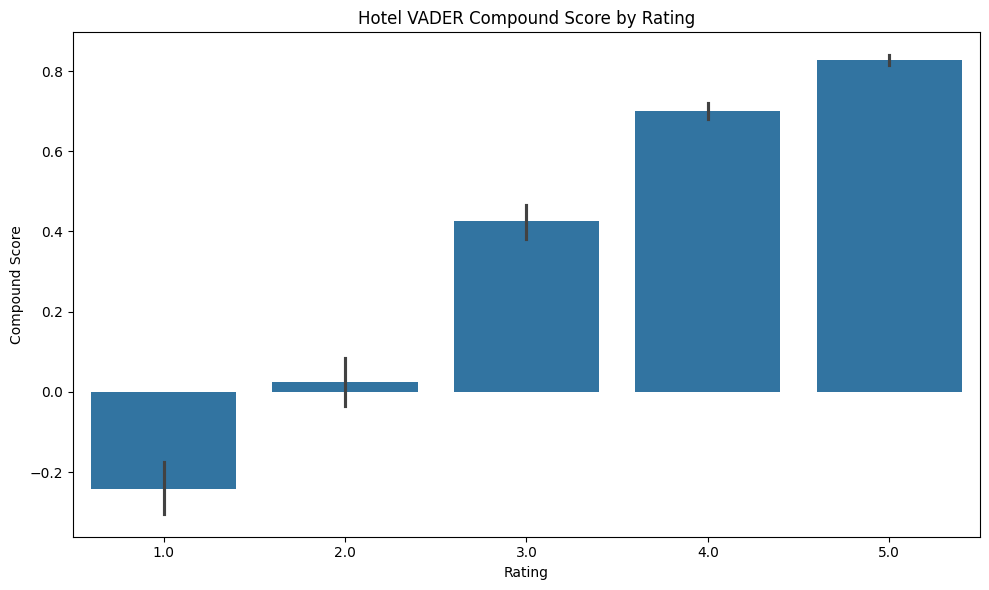

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(data=hotel_sentiment, x='Rating', y='vader_compound')
plt.title('Hotel VADER Compound Score by Rating')
plt.xlabel('Rating')
plt.ylabel('Compound Score')
plt.tight_layout()
plt.show()


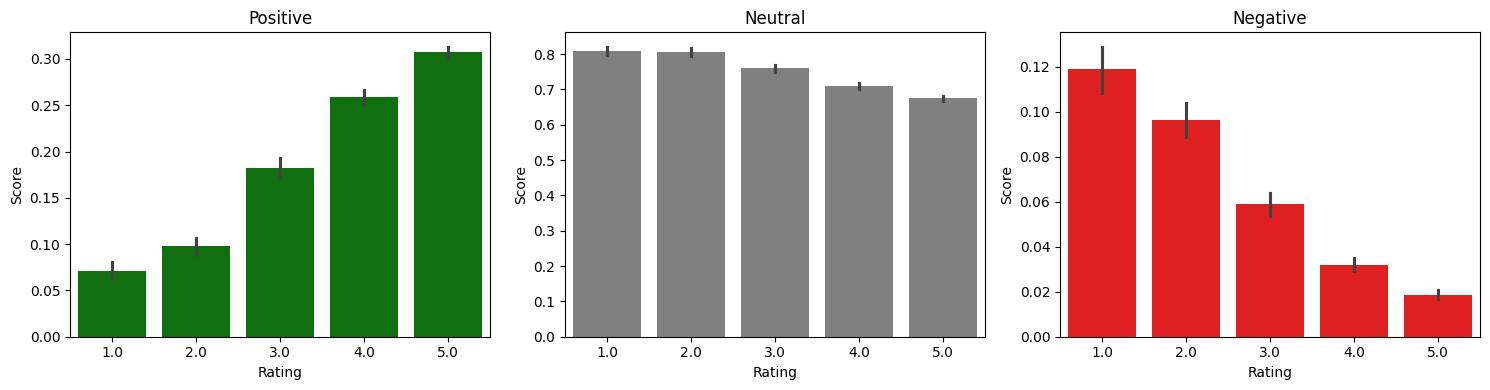

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.barplot(data=hotel_sentiment, x='Rating', y='vader_pos', ax=axes[0], color='green')
sns.barplot(data=hotel_sentiment, x='Rating', y='vader_neu', ax=axes[1], color='gray')
sns.barplot(data=hotel_sentiment, x='Rating', y='vader_neg', ax=axes[2], color='red')

axes[0].set_title('Positive')
axes[1].set_title('Neutral')
axes[2].set_title('Negative')

for ax in axes:
    ax.set_xlabel('Rating')
    ax.set_ylabel('Score')

plt.tight_layout()
plt.show()

### 5.3 TripAdvisor Sentiment Analysis

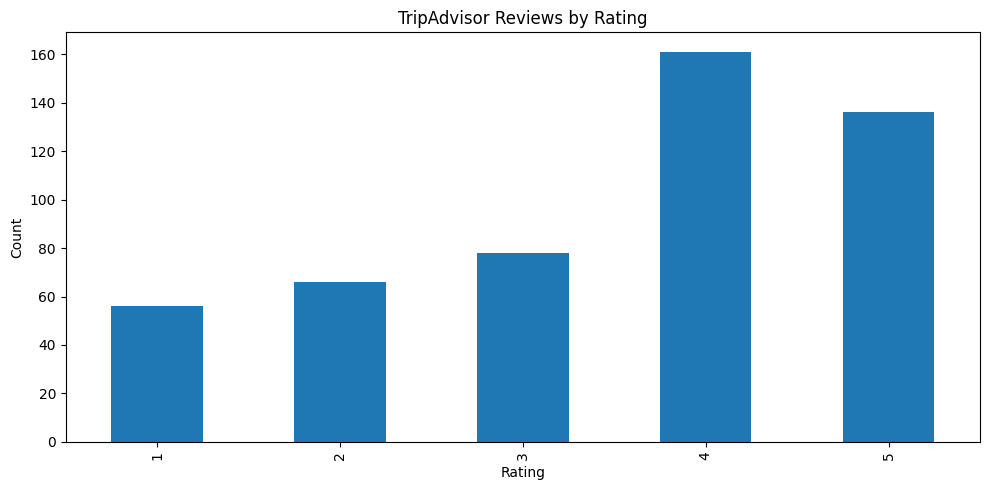

In [25]:
ax = tripadvisor_sentiment['Rating'].value_counts().sort_index().plot(
    kind='bar',
    title='TripAdvisor Reviews by Rating',
    figsize=(10, 5)
)
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

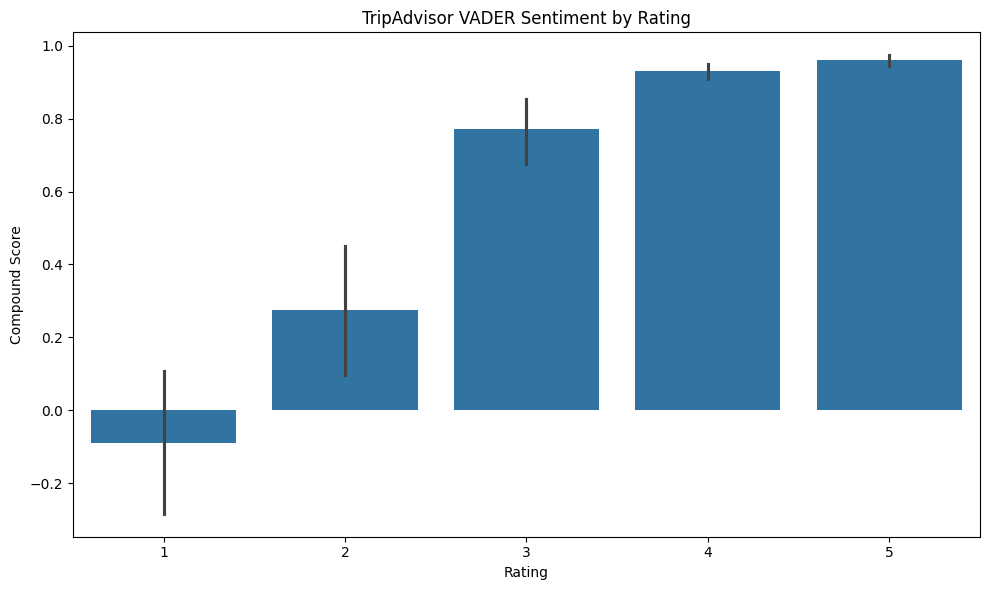

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(data=tripadvisor_sentiment, x='Rating', y='vader_compound')
plt.title('TripAdvisor VADER Sentiment by Rating')
plt.xlabel('Rating')
plt.ylabel('Compound Score')
plt.tight_layout()
plt.show()

## Section 6: Contrastive Word Clouds

### 6.1 Word Cloud Helper Functions

In [27]:
def find_probable_names(text):
    probable = set()
    sentences = re.split(r'(?<=[.!?])\s+', text)  # simple sentence split

    for sent in sentences:
        words = sent.split()
        for i, w in enumerate(words):
            # skip empty tokens
            if not w:
                continue

            # remove punctuation around token
            token = re.sub(r'^\W+|\W+$', '', w)

            # ignore empty after cleaning
            if not token:
                continue

            # rule: inside sentence AND starts uppercase AND rest lowercase
            if i > 0 and token[0].isupper() and token[1:].islower():
                probable.add(token.lower())
    return probable


In [28]:
def tokenize_filter_names(text, global_names):
    # split into words
    raw_tokens = re.findall(r"\b\w+\b", text)
    tokens = []

    for w in raw_tokens:
        lw = w.lower()

        # remove anything marked globally as a name
        if lw in global_names:
            continue

        tokens.append(lw)
    return tokens

In [29]:
def make_weighted_wordcloud(texts_main, texts_ref, title, ratio_threshold=1.2, min_freq=3, save_path=None):
    # Step A: collect all candidate names from both groups
    probable_names = set()
    for t in list(texts_main) + list(texts_ref):
        probable_names |= find_probable_names(str(t))

    # Step B: tokenize while filtering names
    main_tokens = []
    ref_tokens = []

    for t in texts_main:
        main_tokens.extend(tokenize_filter_names(str(t), probable_names))

    for t in texts_ref:
        ref_tokens.extend(tokenize_filter_names(str(t), probable_names))

    # Step C: frequency comparison
    c1 = Counter(main_tokens)
    c2 = Counter(ref_tokens)

    weights = {}
    for w, f_main in c1.items():
        if f_main < min_freq:
            continue
        f_ref = c2.get(w, 0) + 1e-6
        ratio = f_main / f_ref
        if ratio >= ratio_threshold:
            weights[w] = ratio

    if not weights:
        print(f"{title}: No distinctive words found.")
        return

    wc = WordCloud(width=800, height=400, background_color="white")
    wc.generate_from_frequencies(weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=100, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

### 6.2 Airbnb Word Clouds


AIRBNB WORD CLOUDS
Saved: WordClouds_Combined/airbnb_positive.png


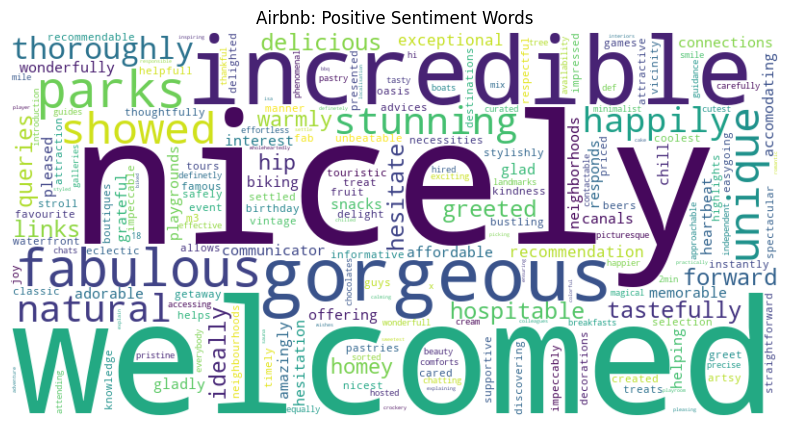

Saved: WordClouds_Combined/airbnb_negative.png


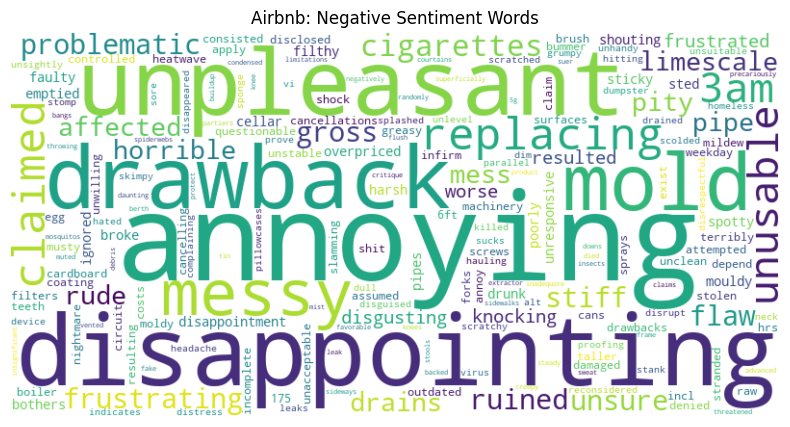

In [30]:
os.makedirs("WordClouds_Combined", exist_ok=True)

print("\n" + "="*80)
print("AIRBNB WORD CLOUDS")
print("="*80)

pos_texts = airbnb_merged.loc[
    airbnb_merged.roberta_neg < airbnb_merged.roberta_pos, "Review"
]
neg_texts = airbnb_merged.loc[
    airbnb_merged.roberta_pos < airbnb_merged.roberta_neg, "Review"
]
make_weighted_wordcloud(
    pos_texts, neg_texts, 
    "Airbnb: Positive Sentiment Words",
    ratio_threshold=1.0,
    min_freq=1,
    save_path="WordClouds_Combined/airbnb_positive.png"
)

make_weighted_wordcloud(
    neg_texts, pos_texts, 
    "Airbnb: Negative Sentiment Words",
    ratio_threshold=1.0,
    min_freq=1,
    save_path="WordClouds_Combined/airbnb_negative.png"
)


Generating cluster-specific word clouds...
Saved: WordClouds_Combined/cluster_000_pos.png


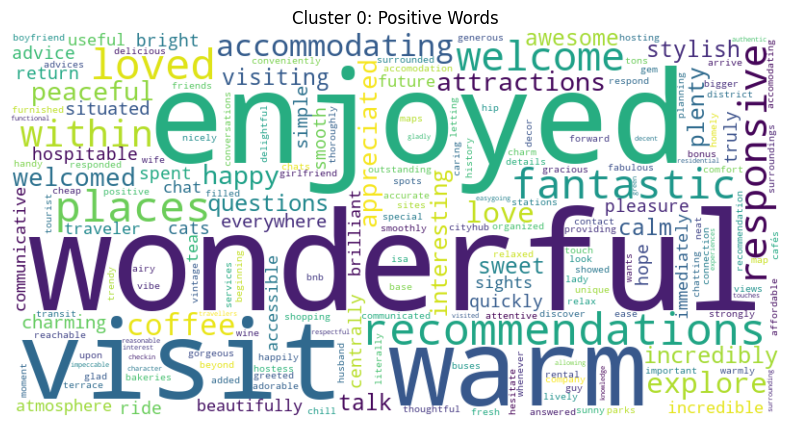

Saved: WordClouds_Combined/cluster_000_neg.png


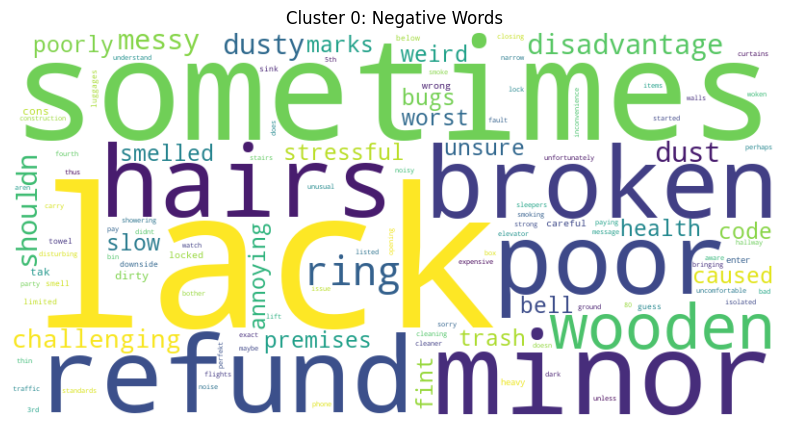

Saved: WordClouds_Combined/cluster_001_pos.png


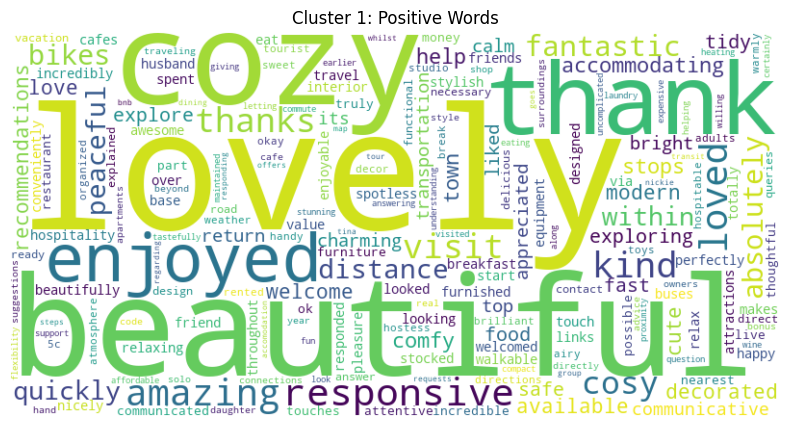

Saved: WordClouds_Combined/cluster_001_neg.png


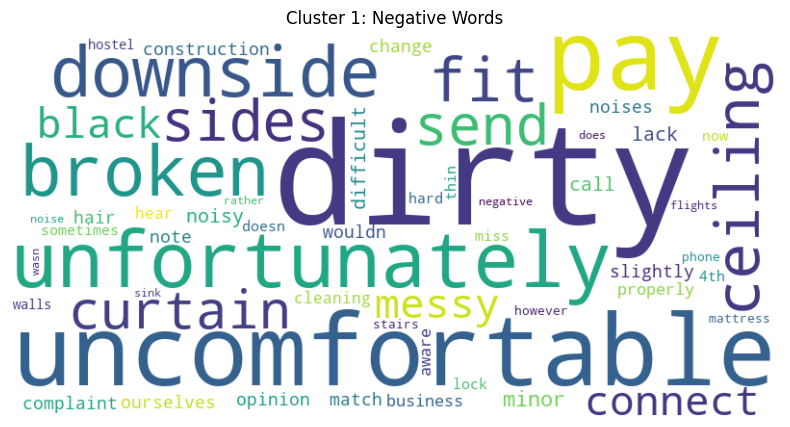

Saved: WordClouds_Combined/cluster_002_pos.png


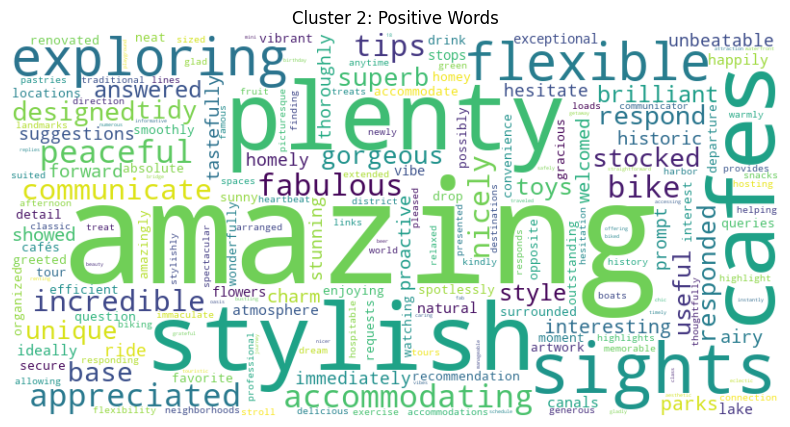

Saved: WordClouds_Combined/cluster_002_neg.png


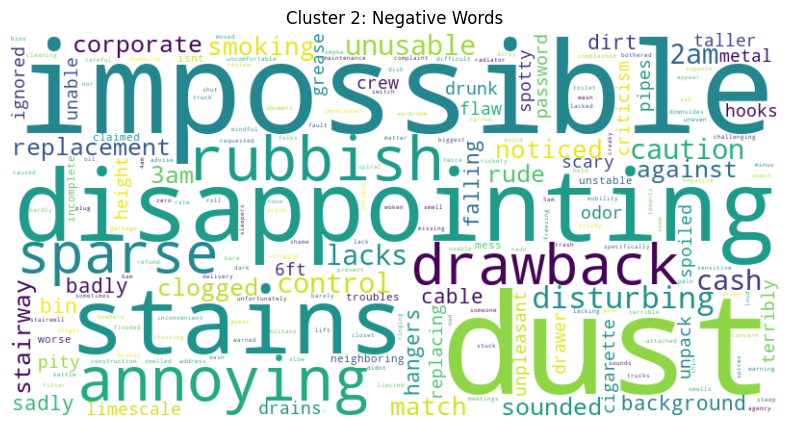

Saved: WordClouds_Combined/cluster_003_pos.png


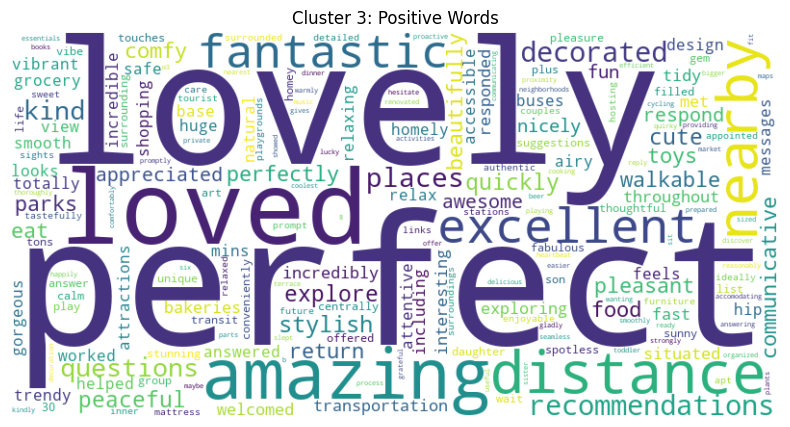

Saved: WordClouds_Combined/cluster_003_neg.png


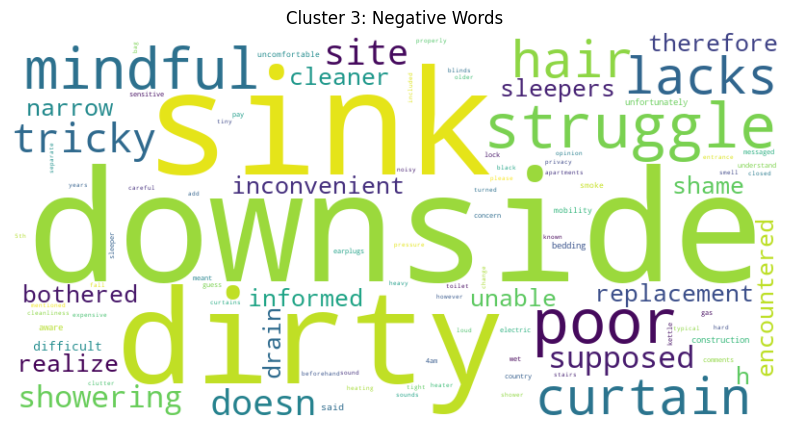

Saved: WordClouds_Combined/cluster_004_pos.png


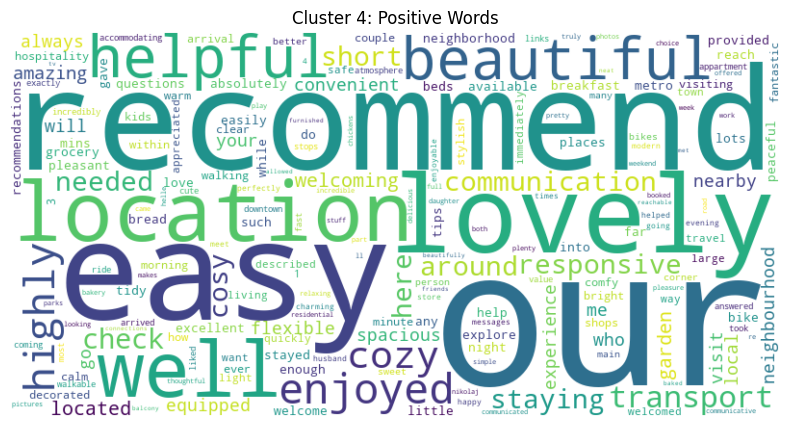

Saved: WordClouds_Combined/cluster_004_neg.png


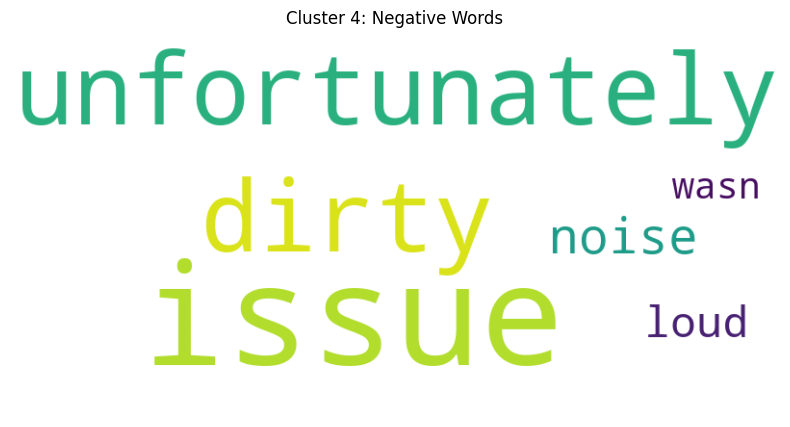

Saved: WordClouds_Combined/cluster_005_pos.png


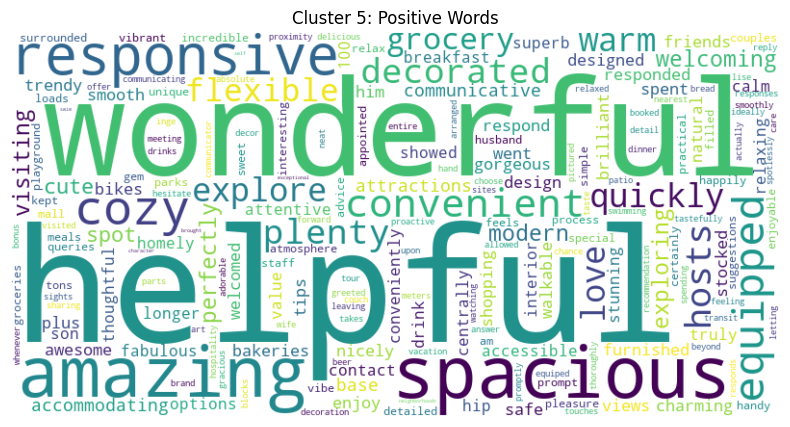

Saved: WordClouds_Combined/cluster_005_neg.png


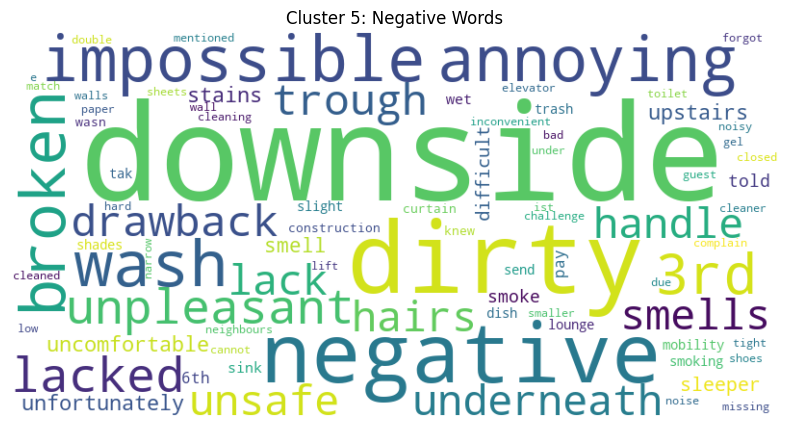

Saved: WordClouds_Combined/cluster_006_pos.png


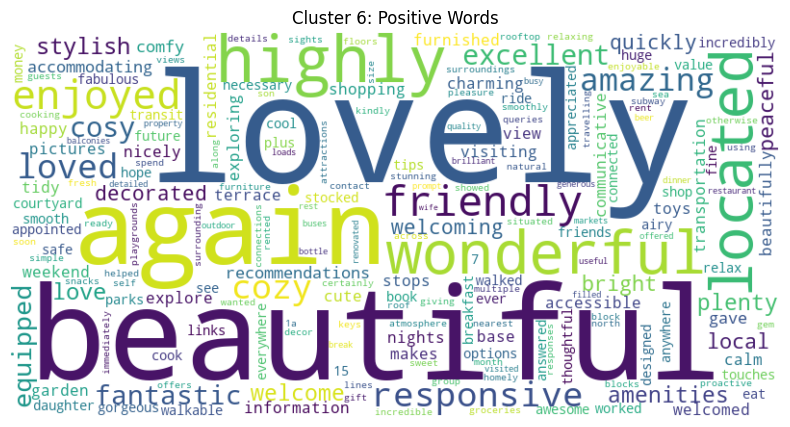

Saved: WordClouds_Combined/cluster_006_neg.png


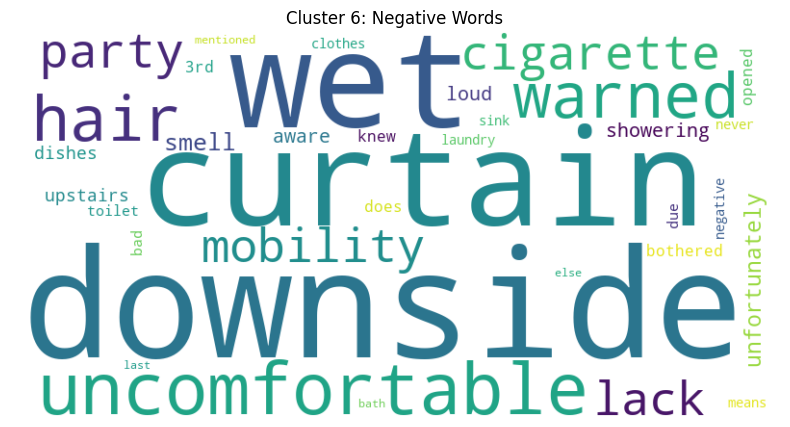

Saved: WordClouds_Combined/cluster_007_pos.png


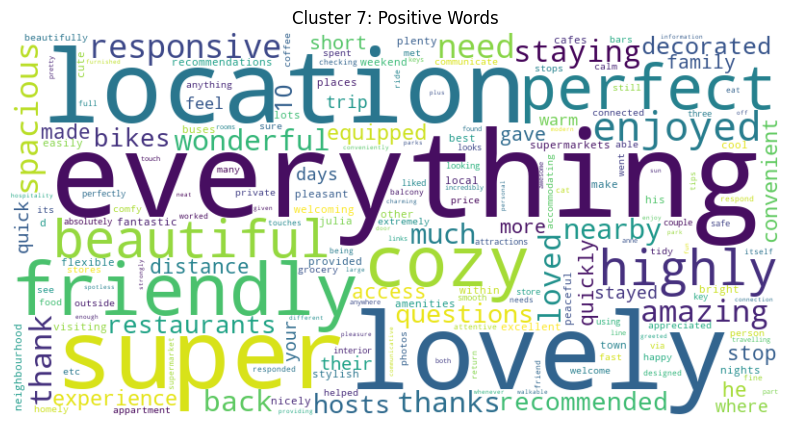

Saved: WordClouds_Combined/cluster_007_neg.png


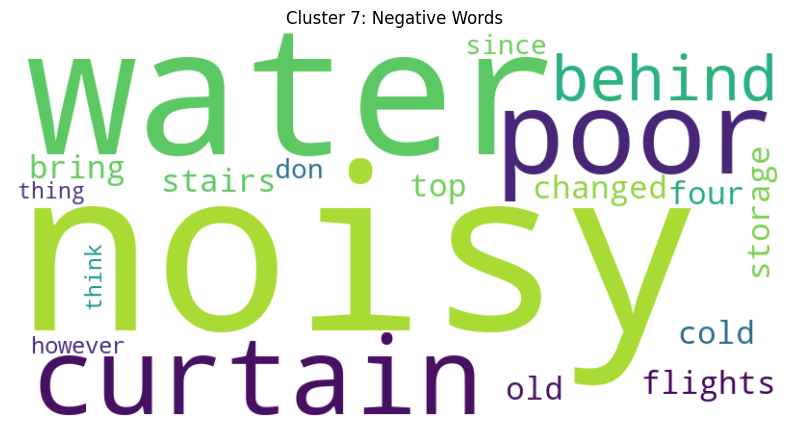

Saved: WordClouds_Combined/cluster_009_pos.png


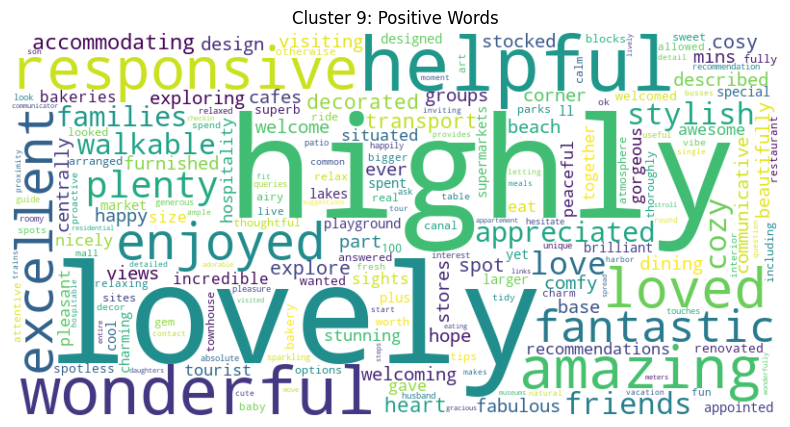

Saved: WordClouds_Combined/cluster_009_neg.png


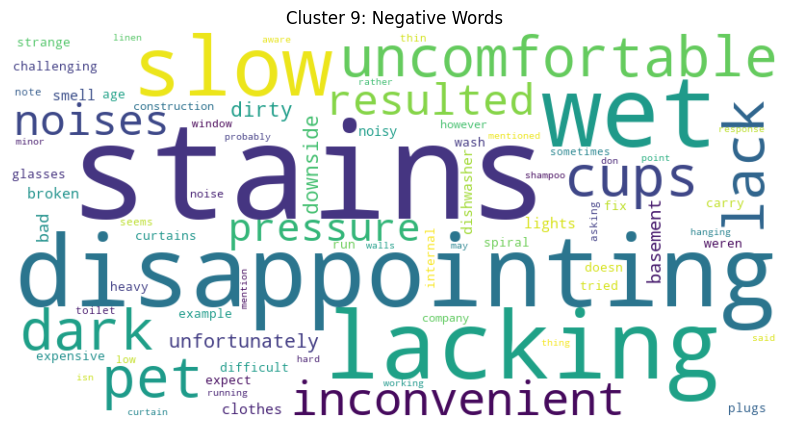

Saved: WordClouds_Combined/cluster_010_pos.png


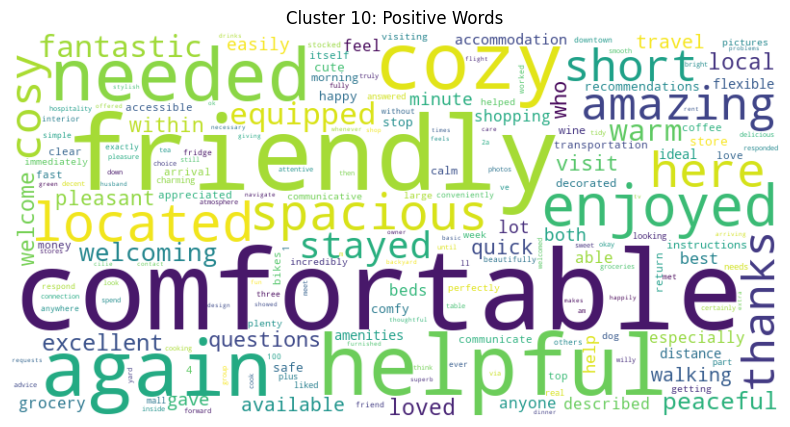

Saved: WordClouds_Combined/cluster_010_neg.png


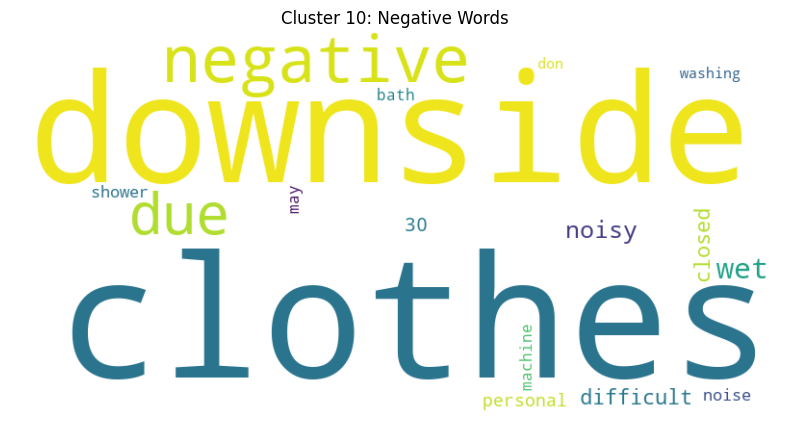

Saved: WordClouds_Combined/cluster_011_pos.png


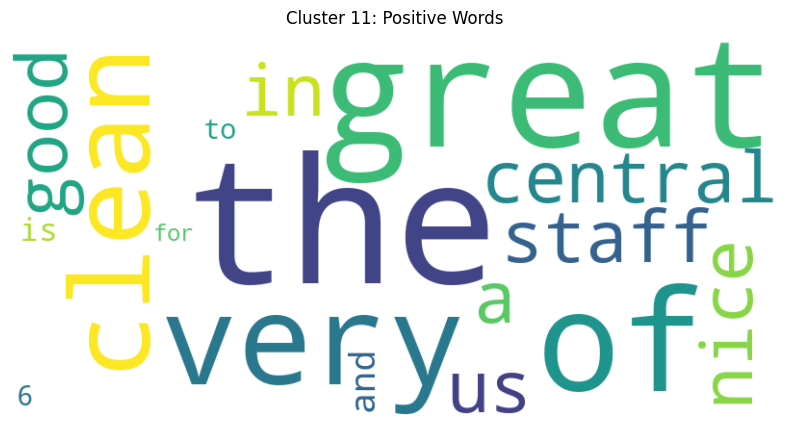

Cluster 11: Negative Words: No distinctive words found.
Saved: WordClouds_Combined/cluster_012_pos.png


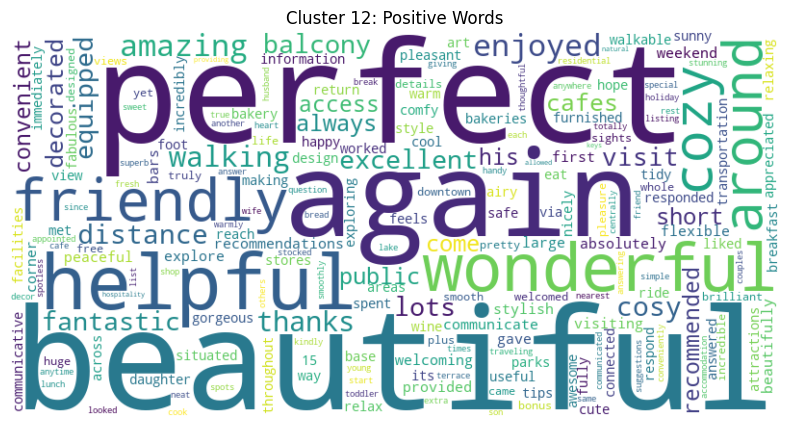

Saved: WordClouds_Combined/cluster_012_neg.png


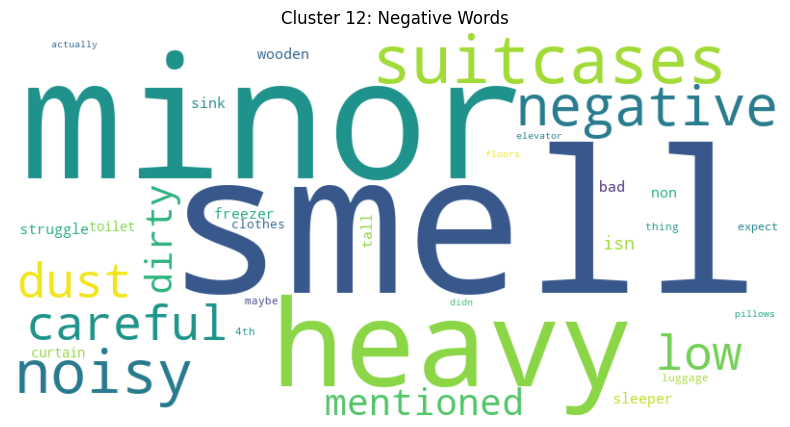

Saved: WordClouds_Combined/cluster_013_pos.png


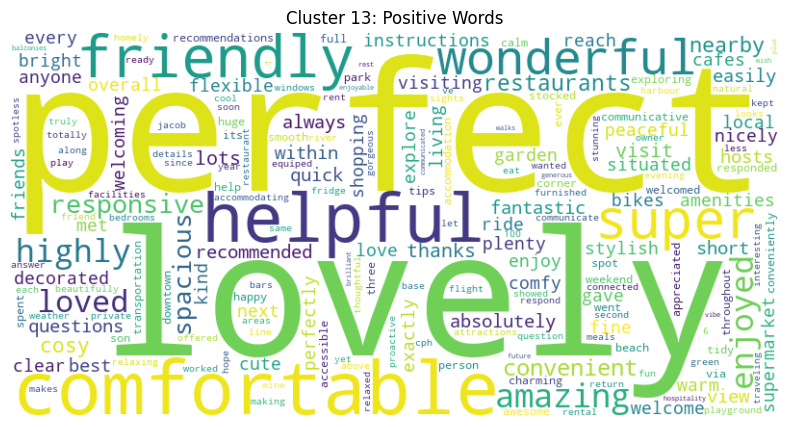

Saved: WordClouds_Combined/cluster_013_neg.png


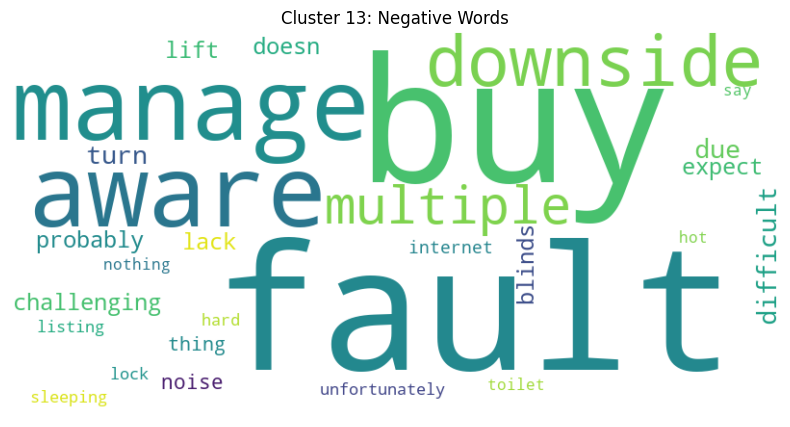

Saved: WordClouds_Combined/cluster_014_pos.png


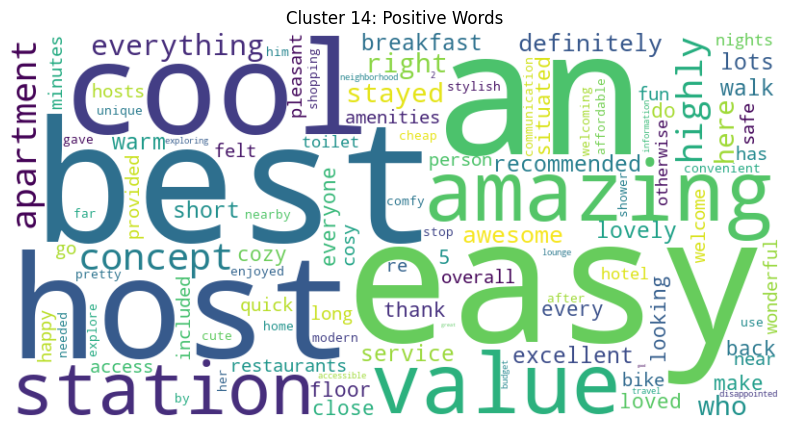

Saved: WordClouds_Combined/cluster_014_neg.png


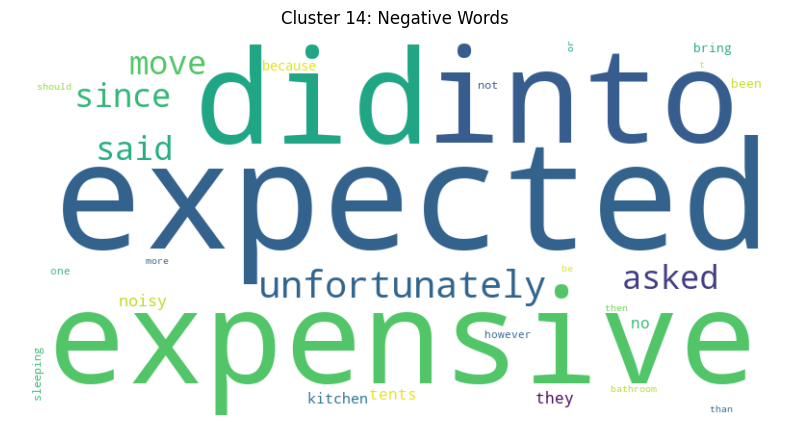

Saved: WordClouds_Combined/cluster_leaveoneout_pos.png


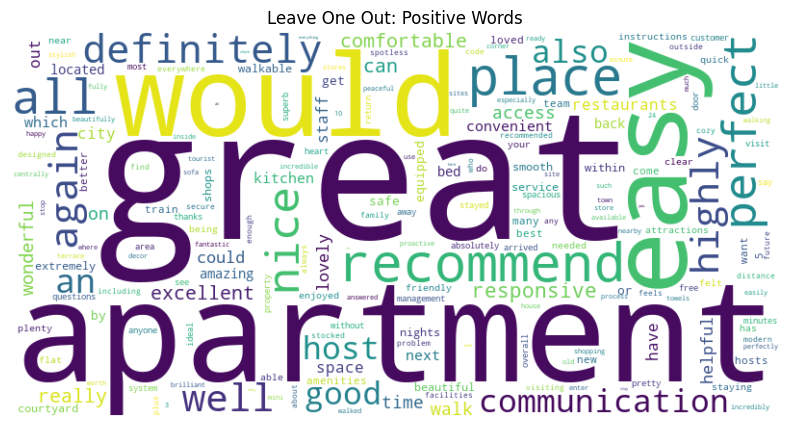

Saved: WordClouds_Combined/cluster_leaveoneout_neg.png


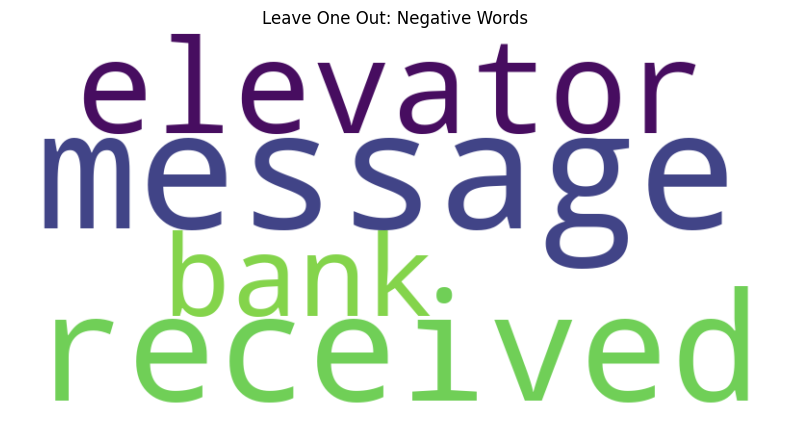

✓ Cluster word clouds complete!


In [31]:
print("\nGenerating cluster-specific word clouds...")

clusters = sorted(airbnb_merged.cluster_kmeans.unique())

for cluster_id in clusters:
    cluster_data = airbnb_merged[airbnb_merged.cluster_kmeans == cluster_id]
    
    pos_reviews = cluster_data.loc[
        cluster_data.roberta_pos > cluster_data.roberta_neg, "Review"
    ]
    neg_reviews = cluster_data.loc[
        cluster_data.roberta_neg > cluster_data.roberta_pos, "Review"
    ]
    
    if cluster_id == 100:
        cluster_name = "Leave One Out"
        pos_title = f"{cluster_name}: Positive Words"
        neg_title = f"{cluster_name}: Negative Words"
        pos_path = f"WordClouds_Combined/cluster_leaveoneout_pos.png"
        neg_path = f"WordClouds_Combined/cluster_leaveoneout_neg.png"
    else:
        cluster_name = f"Cluster {cluster_id}"
        pos_title = f"{cluster_name}: Positive Words"
        neg_title = f"{cluster_name}: Negative Words"
        pos_path = f"WordClouds_Combined/cluster_{cluster_id:03d}_pos.png"
        neg_path = f"WordClouds_Combined/cluster_{cluster_id:03d}_neg.png"
    
    if len(pos_reviews) > 0 and len(neg_reviews) > 0:
        make_weighted_wordcloud(
            pos_reviews, neg_reviews,
            pos_title,
            save_path=pos_path
        )
        make_weighted_wordcloud(
            neg_reviews, pos_reviews,
            neg_title,
            save_path=neg_path
        )

print("✓ Cluster word clouds complete!")

### 6.3 Hotel Word Clouds


HOTEL WORD CLOUDS
Saved: WordClouds_Combined/hotel_high_rating.png


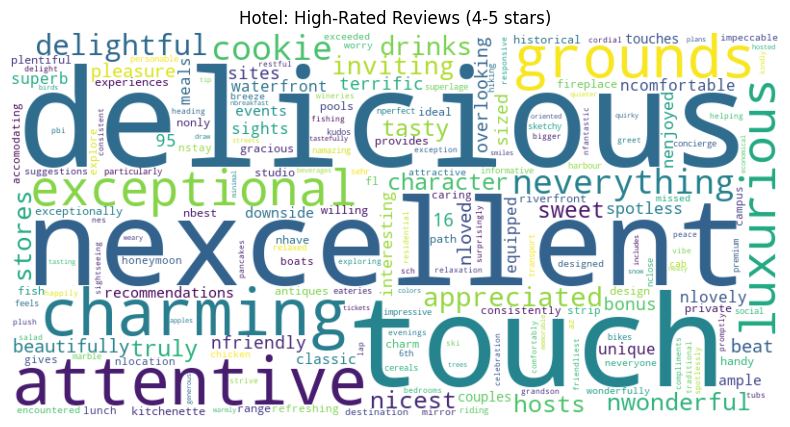

Saved: WordClouds_Combined/hotel_low_rating.png


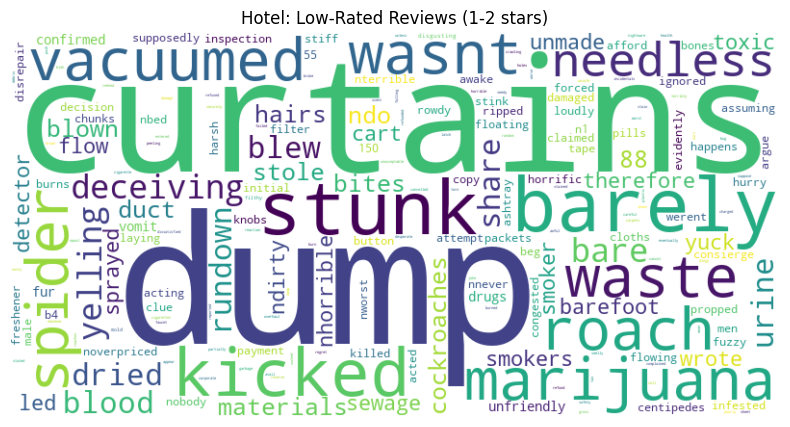

In [32]:
print("\n" + "="*80)
print("HOTEL WORD CLOUDS")
print("="*80)

high_rating = hotel_sentiment.loc[hotel_sentiment['Rating'] >= 4.0, "Review"]
low_rating = hotel_sentiment.loc[hotel_sentiment['Rating'] <= 2.0, "Review"]

if len(high_rating) > 0 and len(low_rating) > 0:
    make_weighted_wordcloud(
        high_rating, low_rating,
        "Hotel: High-Rated Reviews (4-5 stars)",
        save_path="WordClouds_Combined/hotel_high_rating.png"
    )
    make_weighted_wordcloud(
        low_rating, high_rating,
        "Hotel: Low-Rated Reviews (1-2 stars)",
        save_path="WordClouds_Combined/hotel_low_rating.png"
    )

## Extra: Export Results

In [34]:
os.makedirs("analysis_results", exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

airbnb_out = f"analysis_results/airbnb_sentiment_{timestamp}.csv"
airbnb_merged.to_csv(airbnb_out, index=False)
print(f"✓ Saved: {airbnb_out}")

hotel_out = f"analysis_results/hotel_sentiment_{timestamp}.csv"
hotel_sentiment.to_csv(hotel_out, index=False)
print(f"✓ Saved: {hotel_out}")

ta_out = f"analysis_results/tripadvisor_sentiment_{timestamp}.csv"
tripadvisor_sentiment.to_csv(ta_out, index=False)
print(f"✓ Saved: {ta_out}")

print("\n✓ All results exported!")

✓ Saved: analysis_results/airbnb_sentiment_20251205_151650.csv
✓ Saved: analysis_results/hotel_sentiment_20251205_151650.csv
✓ Saved: analysis_results/tripadvisor_sentiment_20251205_151650.csv

✓ All results exported!
